In [1]:
import pickle

import numpy as np

import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import arviz as az

import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample


from models import deconvolution

from scipy.stats import gaussian_kde


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

torch.set_default_device(device)

/home/akseli/dippa/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Inverse problem 

In [2]:
# Parameters
T = 0.05
N = 100
domain = [0, 1]
sigma_noise = 0.05
mu_u = -1
sigma_2_u = 0.05**2

n = 2*N
t = np.linspace(domain[0],domain[1], N)
t = np.round(t, 3)
d_k = 40

h = domain[1] / N

params = [0, 0.8, 0.1, 1.0, 0]

def problem_system(grid: np.array, params)-> np.array:

    output = np.zeros(grid.shape)
    for idx, point in enumerate(grid):
        if point <= 0.1:
            output[idx] = params[0]
        elif point <= 0.2:
            output[idx] = params[1]
        elif point <= 0.4:
            output[idx] = params[2]
        elif point <= 0.75:
            #output[idx] = params[3]
            output[idx] = 0.3*np.sin(2*np.pi*point*2)+params[3]
        else:
            output[idx] = point*params[4]
    
    return output



## Convolution matrix

In [3]:
model = deconvolution(int(np.round(n/2)), int(n/16), 'reflect')
A = model.linear_operator(n)
A = A[1::2, :]

#A[0,0] = 0
#A[-1, -1] = 0

## Data Generation

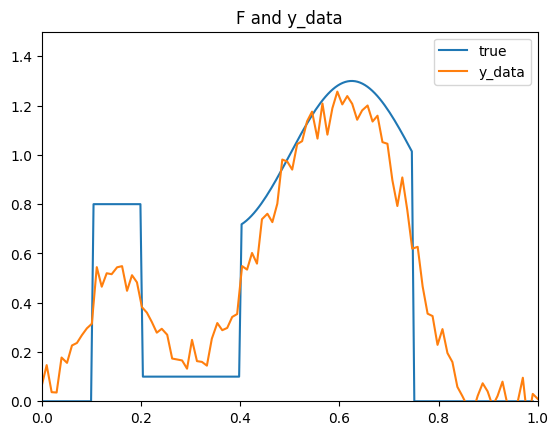

In [4]:
# Generate grid points
x = np.linspace(0, domain[1] - h, n)

# Construct the function f
f = problem_system(x, params)
#f = np.sin(10*x-0.2)
f = A@f
ind = f > 0
f *= ind

# Create y_data with noise
y_data = f + np.random.normal(0, sigma_noise, f.shape)

f = problem_system(x, params)

# Plot f and w
plt.figure()
plt.plot(x, f, label='true')
plt.plot(t, y_data, label='y_data')
plt.axis([domain[0], domain[1], 0, 1.5])
plt.title('F and y_data')
plt.legend()
plt.show()

Old targets

## Pyro BNN

In [5]:
class BNN(PyroModule):

    def __init__(self, h1, h2):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](h1, h2)
        self.fc1.weight = PyroSample(dist.Normal(0.,
                                                torch.tensor(0.5)).expand([h2, h1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.5)).expand([h2]).to_event(1))
        
        #self.fc1 = nn.Linear(h1, h2)

        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Cauchy(0.,
                                                torch.tensor(0.5)).expand([h2, h2]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.05)).expand([h2]).to_event(1))

        self.fc3 = PyroModule[nn.Linear](h1, h2)
        self.fc3.weight = PyroSample(dist.Normal(0.,
                                                torch.tensor(0.5)).expand([h2, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.05)).expand([h2]).to_event(1))

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        
        x = x#.reshape(-1, 1)

        mu = self.relu(self.fc1(x))#.squeeze()
        mu = self.relu(self.fc2(mu))
        mu = self.relu(self.fc3(mu))
        #mu = x
        sigma = pyro.sample("sigma", dist.Uniform(0.,
                                                torch.tensor(0.05)))
    
        with pyro.plate("data", 200):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        
        return mu

In [6]:
# Convert data to PyTorch tensors
x_train = torch.from_numpy(t).float()
y_train = torch.from_numpy(y_data).float()


## Load BNN model for signals, Prior

In [7]:
bnn_model = BNN(h1=N, h2=n)

In [8]:
predictive = torch.load('../bnn_prior_cpu.pt')

#### Generate prior for the y

In [9]:
y_train.device

device(type='cpu')

In [10]:
prior_bnn = predictive(y_train)

In [11]:
prior_bnn = prior_bnn['obs']
prior_bnn.shape

torch.Size([5000, 200])

In [12]:
prior = gaussian_kde(prior_bnn.cpu().numpy().T)

prior_test = prior(f)


#### Plotting the prior

In [13]:
prior_test

array([1.44071071e-23])

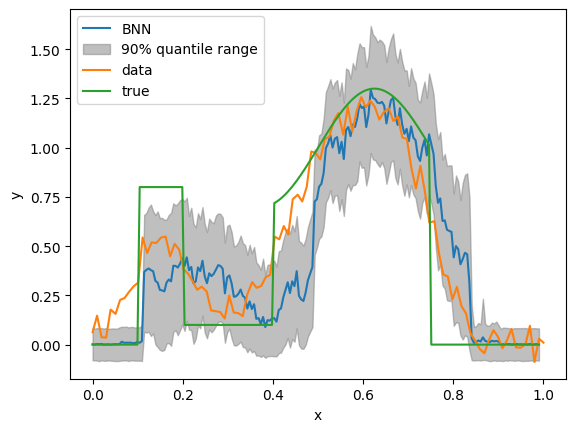

In [14]:
# Calculate mean and quantiles
mean_preds = torch.mean(prior_bnn, axis=0).cpu()
lower_quantile = torch.quantile(prior_bnn, 0.05, axis=0).cpu()
upper_quantile = torch.quantile(prior_bnn, 0.95, axis=0).cpu()

# Plot the mean prediction
plt.plot(x, mean_preds, label='BNN')

# Plot the quantile range as a shaded area
plt.fill_between(x, lower_quantile, upper_quantile, color='gray', alpha=0.5, label='90% quantile range')

# Plot the true data and the true function
plt.plot(t, y_data, label='data')
plt.plot(x, f, label='true')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()


## Sampling with NUTS

It is not working yet, I can't seem to sample the prior correctly. Have asked Pyro forum for help. 

The code works with just using a Gaussian prior. 

In [15]:
A.shape

(100, 200)

In [16]:
import pyro
import pyro.distributions as dist
import pyro.infer

from torch.distributions import constraints
from pyro.infer import TraceEnum_ELBO, config_enumerate, MCMC, NUTS
from pyro.ops.indexing import Vindex
from tqdm.auto import trange
from pyro.optim import Adam


predictive = pyro.poutine.block(predictive, hide_all=True)
predictive.num_samples = 1
A = torch.tensor(A, dtype=torch.float32)    # shape [100, 200]
y_data = torch.tensor(y_data, dtype=torch.float32) # shape [100, 1]
f_gpu = torch.tensor(f, dtype=torch.float32) # shape [100, 1]


def inverse_model(A, y_data):
    
    n = A.size(1)  # Number of features
    prior_samples = pyro.param('prior', prior_bnn) # shape [5000, 200]
    
    sigma = pyro.sample("sigma", dist.Uniform(0., 0.05)).to(A.device)

    omega = pyro.sample("omega", dist.Normal(torch.mean(prior_samples, axis=0), 0.05).expand([n]).to_event(1)).to(A.device)
    
    print(prior(omega.detach().numpy()))
    # Want to compare this to y_data
    # and get omega as the solution
    mu = torch.matmul(A, omega)
        
    with pyro.plate("data", y_data.shape[0]):
        pyro.sample("obs", prior(omega.detach().numpy()), obs=y_data)
    return omega




nuts_kernel = NUTS(inverse_model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=100)
mcmc.run(A, y_data)

Warmup:   0%|          | 0/200 [00:00, ?it/s]

[3.02669828e+59]
[0.]
[0.]


AttributeError: 'numpy.ndarray' object has no attribute 'log_prob'

In [ ]:
mcmc.get_samples()

AttributeError: 'NoneType' object has no attribute 'items'

## MCMC from scratch

In [17]:
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm

In [18]:
def model(A, x):
    return np.matmul(A, x)


def neg_log_likelihood_without_sigma(x, y_data, A):
    'Derived using pen and paper'
    n = len(x)
    residual =  y_data - model(A, x)
    return  1/2*sum(residual**2)


def neg_log_likelihood_sigma(sigma, y_data, A, x):
    n = len(x)
    residual =  y_data - model(A, x)
    return n/2*np.log(2*np.pi) + n*np.log(sigma) +  1/2*sum(residual**2)/sigma**2


res = minimize(neg_log_likelihood_without_sigma,
                mean_preds,
                method='nelder-mead',
                args=(y_data, A),
                options={'xatol': 1e-8,
                'disp': True})
theta_neg_log = res.x
print(f'Theta: {theta_neg_log}\n')


res = minimize(neg_log_likelihood_sigma,
                1,
                method='nelder-mead',
                args=(y_data, A, theta_neg_log),
                options={'xatol': 1e-8,
                'disp': True})
sigma = res.x
print(f'Sigma: {sigma}')

/tmp/ipykernel_1655056/201519606.py:18: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(neg_log_likelihood_without_sigma,


Theta: [ 1.91491237e-03 -4.09168948e-04  7.52711017e-03 -2.10172613e-03
  7.88387028e-04 -1.98615110e-03 -5.25246491e-04  9.54920659e-04
  7.98018649e-04  6.38334968e-05  5.58305066e-03  5.22470009e-03
  2.33672024e-03  2.87453327e-02  7.00361328e-03 -8.52200203e-03
  9.03740246e-03  1.11533254e-02  9.21535306e-03  4.52612527e-04
  7.75577594e-03 -1.66485878e-03  2.54102703e-02  3.37892652e-01
  4.64329243e-01  1.03695905e+00  5.92879534e-01  7.65612125e-01
  3.16785240e+00  1.91918814e+00  8.21542919e-01  2.23576590e-01
  5.93906688e-03  2.39649868e+00  5.70876658e-01  4.61563051e-01
  7.20084161e-02  1.50050640e+00  4.15060997e-01  2.96422124e+00
  1.05551481e+00 -1.42565560e+00  8.31695199e-02 -5.29198647e-01
  1.56861216e-01  3.94157052e-01  1.34580970e-01  2.07288072e-01
 -4.94285107e-01 -9.31951046e-01 -8.12494576e-01 -2.14163914e-01
  2.30008751e-01  4.72924918e-01  3.46795917e-01  6.10197663e-01
  1.14176854e-01  8.35240126e-01  1.59649420e+00 -7.39583015e-01
 -1.50166109e-01  

TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

In [88]:
from pymcmcstat.MCMC import MCMC
mcstat = MCMC()

# Adding data and initializing parameters for the MCMC
mcstat.data.add_data_set(A, y_data)
for ii in range(n):
    mcstat.parameters.add_model_parameter(name=f'x_{ii}', theta0=0.1, minimum=0, maximum=3)



mcstat.simulation_options.define_simulation_options(nsimu=3000,
                                                    method='am',
                                                    adaptint=20,
                                                    burnintime=100,
                                                    verbosity=1,
                                                    waitbar=1)

def ssfun(x, data):
    'Derived using pen and paper'
    A = data.xdata[0].reshape(100,200)
    y_data = data.ydata[0]
    n = len(x)
    x = x.reshape(-1,1)
    residual =  y_data - model(A, x)
    return  1/2*sum(residual**2)

def log_prior(params, a, b):
    # Evaluate the KDE log density for the parameter vector
    log_prob = prior(params.reshape(-1, 1))
    return np.sum(log_prob)


mcstat.model_settings.define_model_settings(sos_function=ssfun,
                                            prior_function=log_prior)

# Simulation and extracting results
mcstat.run_simulation()
results = mcstat.simulation_results.results


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
       x_0:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
       x_1:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
       x_2:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
       x_3:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
       x_4:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
       x_5:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
       x_6:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
       x_7:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
       x_8:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
       x_9:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
      x_10:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
      x_11:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
      x_12:      0.10 [ 0.00e+00,      3.00] N( 0.00e+00,      inf)
      x_13:      0.

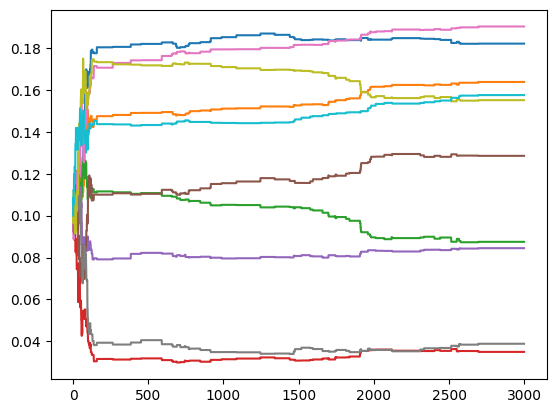

In [89]:
posterior_samples = results['chain']
plt.plot(posterior_samples[:,10:20])
# Compute the mean of each omega_i
mean_omega = np.mean(posterior_samples, axis=0)


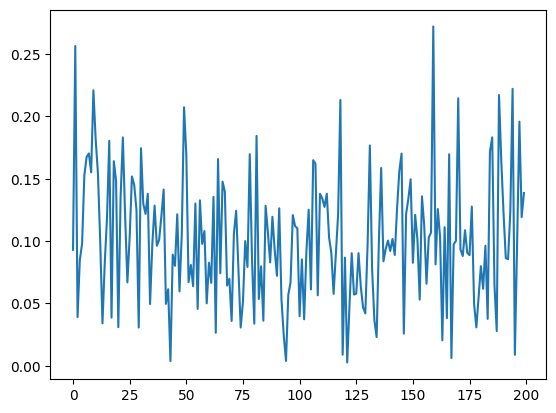

In [90]:
plt.plot(mean_omega)

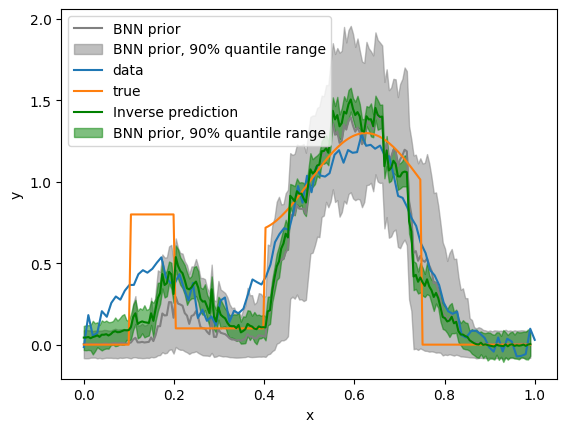

In [57]:
plt.plot(x, mean_preds, color='gray', label='BNN prior')
# Plot the quantile range as a shaded area
plt.fill_between(x, lower_quantile, upper_quantile, color='gray', alpha=0.5, label='BNN prior, 90% quantile range')

# Plot the true data and the true function
plt.plot(t, y_data.cpu(), label='data')
plt.plot(x, f, label='true')

#plt.plot(t, torch.mean(preds_inverse.cpu(), axis=0), label='Inverse prediction')
plt.plot(x, mean_omega, color='g', label='Inverse prediction')
plt.fill_between(x, lower_quantile_omega, upper_quantile_omega, color='g', alpha=0.5, label='BNN prior, 90% quantile range')

# Plot the mean prediction



# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()